In [1]:
import os
from keras.models import Model
from keras.optimizers import Adam
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Dense, Dropout, Flatten
from pathlib import Path
import numpy as np

C:\Users\HP\AppData\Roaming\Python\Python38\site-packages\pandas\core\computation\expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
BATCH_SIZE = 32

train_generator = ImageDataGenerator(
    #rotation_range=90, 
    #                                 brightness_range=[0.1, 0.7],
                  #                   width_shift_range=0.5, 
                                #     height_shift_range=0.5,
                               #      horizontal_flip=True, 
                                 #    vertical_flip=True,     
     validation_split=0.2,
                
                                     ) # VGG16 preprocessing

#test_generator = ImageDataGenerator(preprocessing_function=preprocess_input)

In [3]:
img_Folder = r'Dataset\Dataset'
class_subset = sorted(os.listdir(img_Folder))

traingen = train_generator.flow_from_directory(img_Folder,
                                               target_size=(224, 224),
                                               class_mode='categorical',
                                               classes=class_subset,
                                               subset='training',
                                               batch_size=BATCH_SIZE, 
                                               shuffle=True,
                                               seed=42)

validgen = train_generator.flow_from_directory(img_Folder,
                                               target_size=(224, 224),
                                               class_mode='categorical',
                                               classes=class_subset,
                                               subset='validation',
                                               batch_size=BATCH_SIZE,
                                               shuffle=True,
                                               seed=42)
testgen = train_generator.flow_from_directory(img_Folder,
                                             target_size=(224, 224),
                                             class_mode=None,
                                             classes=class_subset,
                                             batch_size=1,
                                             shuffle=False,
                                             seed=42)

Found 2724 images belonging to 33 classes.
Found 664 images belonging to 33 classes.
Found 3388 images belonging to 33 classes.


In [9]:
import tensorflow as tf
from tensorflow import keras

data_augmentation = tf.keras.Sequential(
  [
    tf.keras.layers.RandomFlip("horizontal",
                      input_shape=(224,
                                  224,
                                  3)),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
  ]
)

In [5]:
from tensorflow.keras import layers

base_model = keras.applications.ResNet50V2(
                            include_top=False, # Exclude ImageNet classifier at the top.
                            weights="imagenet",
                            input_shape=(224, 224, 3))
base_model.trainable = False
inputs = keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = keras.applications.resnet_v2.preprocess_input(x)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.2)(x)  # Regularize with dropout
x = Dense(256, activation='relu')(x)
x = Dropout(0.2)(x)

outputs = layers.Dense(33, activation="softmax", name="pred")(x)

model = keras.Model(inputs, outputs)


    
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0     

In [6]:
from keras.optimizers import Adam
#input_shape = (224, 224, 3)
optim_1 = Adam(learning_rate=0.001)
#n_classes=16

n_steps = traingen.samples // BATCH_SIZE
n_val_steps = validgen.samples // BATCH_SIZE
n_epochs = 50

#resnet_model = create_model(input_shape, n_classes, optim_1, fine_tune=2)
model.compile(optimizer=optim_1, 
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])


In [7]:
early_stop = EarlyStopping(monitor='val_loss',
                           patience=5,
                           restore_best_weights=True,
                           mode='min')

In [8]:
res_history = model.fit(traingen,
                            batch_size=BATCH_SIZE,
                            epochs=n_epochs,
                            validation_data=validgen,
                            steps_per_epoch=n_steps,
                            validation_steps=n_val_steps,
                            callbacks=[early_stop],
                            verbose=1)

Epoch 1/50
 7/85 [=>............................] - ETA: 3:05 - loss: 3.5529 - accuracy: 0.1473

C:\ProgramData\Anaconda3\lib\site-packages\PIL\Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


85/85 [==============================] - 261s 3s/step - loss: 1.4905 - accuracy: 0.5862 - val_loss: 0.5972 - val_accuracy: 0.8297
Epoch 2/50
85/85 [==============================] - 260s 3s/step - loss: 0.5318 - accuracy: 0.8395 - val_loss: 0.4557 - val_accuracy: 0.8594
Epoch 3/50
85/85 [==============================] - 257s 3s/step - loss: 0.4126 - accuracy: 0.8741 - val_loss: 0.4205 - val_accuracy: 0.8797
Epoch 4/50
85/85 [==============================] - 262s 3s/step - loss: 0.2798 - accuracy: 0.9108 - val_loss: 0.4159 - val_accuracy: 0.8703
Epoch 5/50
85/85 [==============================] - 289s 3s/step - loss: 0.2587 - accuracy: 0.9149 - val_loss: 0.4280 - val_accuracy: 0.8797
Epoch 6/50
85/85 [==============================] - 281s 3s/step - loss: 0.1931 - accuracy: 0.9383 - val_loss: 0.3788 - val_accuracy: 0.8906
Epoch 7/50
85/85 [==============================] - 282s 3s/step - loss: 0.1922 - accuracy: 0.9406 - val_loss: 0.3577 - val_accuracy: 0.8891
Epoch 8/50
85/85 [======

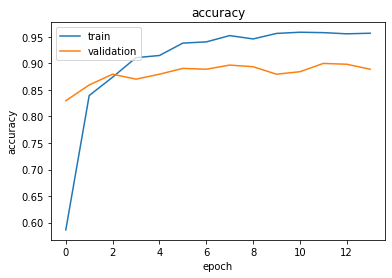

In [9]:
import matplotlib.pyplot as plt

def plot_hist(hist):
    plt.plot(hist.history['accuracy'])
    plt.plot(hist.history['val_accuracy'])
    plt.title('accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

plot_hist(res_history)

In [10]:
from keras.preprocessing import image

img_width, img_height = 224, 224
img = tf.keras.utils.load_img('fino.jpg', target_size = (img_width, img_height))
img = tf.keras.utils.img_to_array(img)
img = np.expand_dims(img, axis = 0)
preds = model.predict(img)
#for cls in traingen.class_indices:
#    print(preds[0][traingen.class_indices[cls]])
MaxPosition=np.argmax(preds)  
print(MaxPosition)
prediction_label=class_subset[MaxPosition]
print(prediction_label) 
class_subset

1/1 [==============================] - 3s 3s/step
29
bread


['Ads',
 'Apple',
 'Cabbage',
 'Cheese',
 'Chicken',
 'Chocolate',
 'Corn',
 'Date',
 'Egg',
 'Eggplant',
 'Fish',
 'Flour',
 'Honey',
 'Lemon',
 'Meat',
 'Miilk',
 'Milk',
 'Mushroom',
 'Pasta',
 'Pea',
 'Pepper',
 'Pizza Base',
 'Potato',
 'Rice',
 'Soy Sauce',
 'Spinach',
 'Toast',
 'Tomato',
 'Yogurt',
 'bread',
 'pastaa',
 'shrimp',
 'soy']

In [11]:
class_subset

['Ads',
 'Apple',
 'Cabbage',
 'Cheese',
 'Chicken',
 'Chocolate',
 'Corn',
 'Date',
 'Egg',
 'Eggplant',
 'Fish',
 'Flour',
 'Honey',
 'Lemon',
 'Meat',
 'Miilk',
 'Milk',
 'Mushroom',
 'Pasta',
 'Pea',
 'Pepper',
 'Pizza Base',
 'Potato',
 'Rice',
 'Soy Sauce',
 'Spinach',
 'Toast',
 'Tomato',
 'Yogurt',
 'bread',
 'pastaa',
 'shrimp',
 'soy']

In [29]:
test_generator = ImageDataGenerator()

testgen = train_generator.flow_from_directory(img_Folder,
                                             target_size=(224,224),
                                             batch_size=1,
                                             class_mode=None,
                                             classes=class_subset, 
                                             shuffle=False,
                                             seed=42)

Found 3388 images belonging to 33 classes.


In [32]:


disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_subset)

disp.plot(cmap=plt.cm.Blues)
plt.show()

<ipython-input-32-3ca2c517018c>:5: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  Y_pred = model.predict_generator(testgen,3388 // BATCH_SIZE+1)


Confusion Matrix


ValueError: Found input variables with inconsistent numbers of samples: [3388, 106]

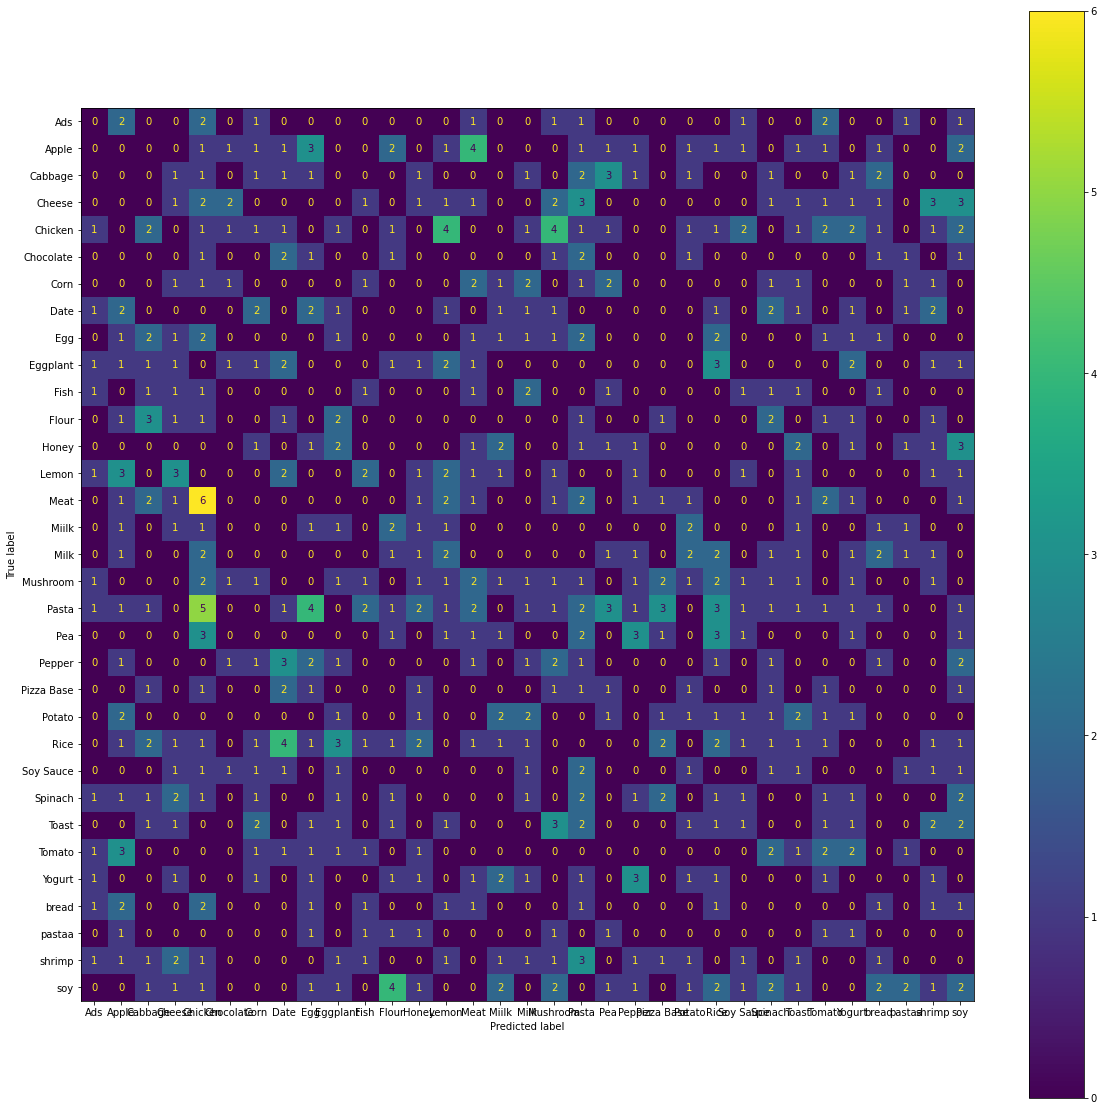

In [26]:
fig, ax = plt.subplots(figsize=(20,20))
disp.plot(ax=ax)

2172/3388 [==================>...........] - ETA: 2:29

C:\ProgramData\Anaconda3\lib\site-packages\PIL\Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


3388/3388 [==============================] - 417s 123ms/step


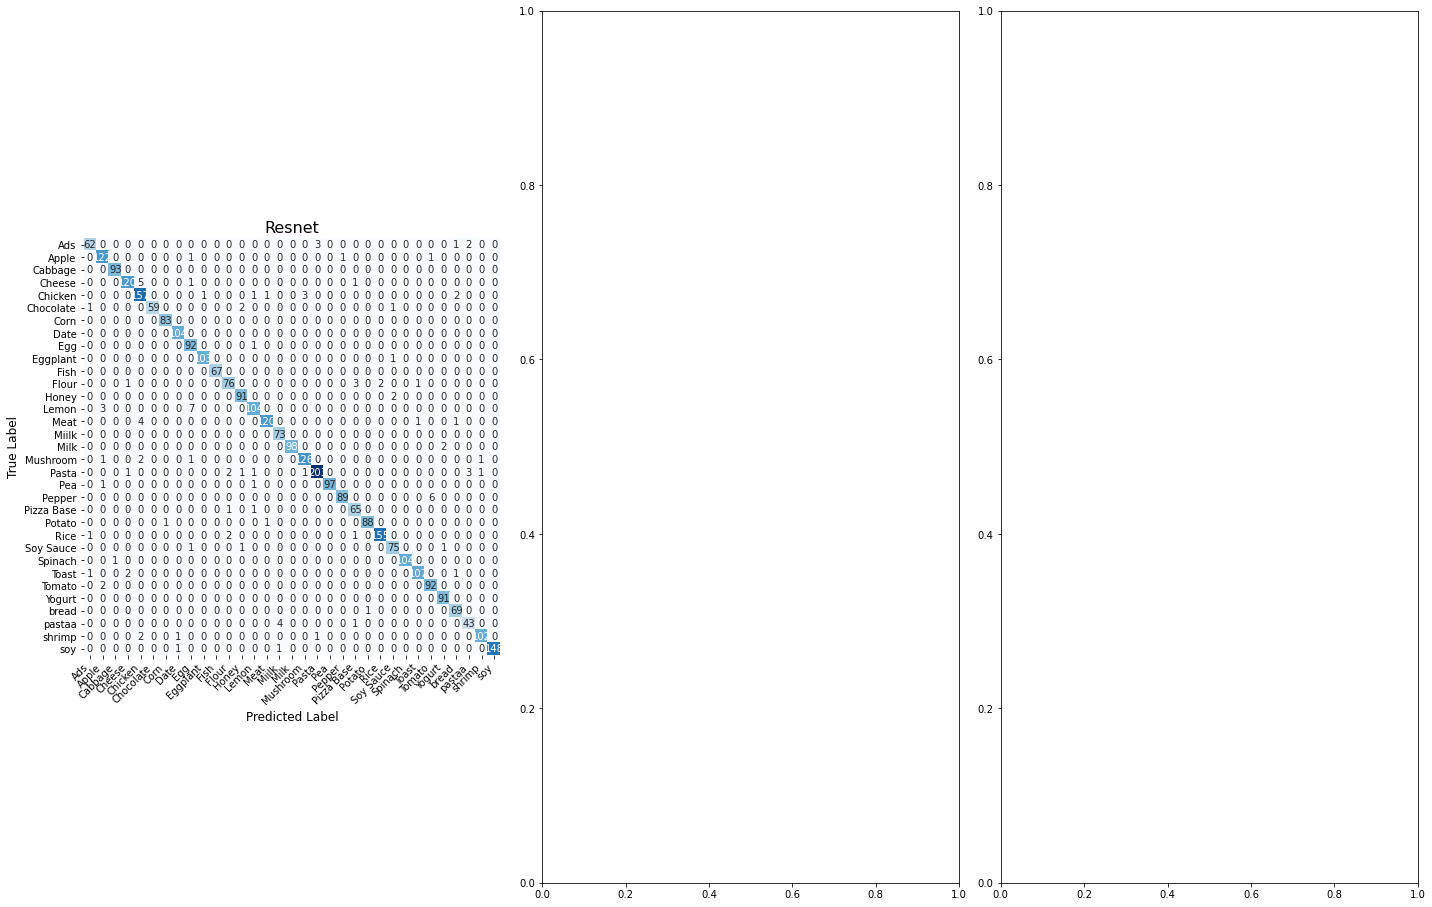

In [33]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Get the names of the ten classes
class_names = testgen.class_indices.keys()

def plot_heatmap(y_true, y_pred, class_names, ax, title):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(
        cm, 
        annot=True, 
        square=True, 
        xticklabels=class_names, 
        yticklabels=class_names,
        fmt='d', 
        cmap=plt.cm.Blues,
        cbar=False,
        ax=ax
    )
    ax.set_title(title, fontsize=16)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
    ax.set_ylabel('True Label', fontsize=12)
    ax.set_xlabel('Predicted Label', fontsize=12)

    
true_classes = testgen.classes
preds = model.predict(testgen)
pred_classes = np.argmax(preds, axis=1)



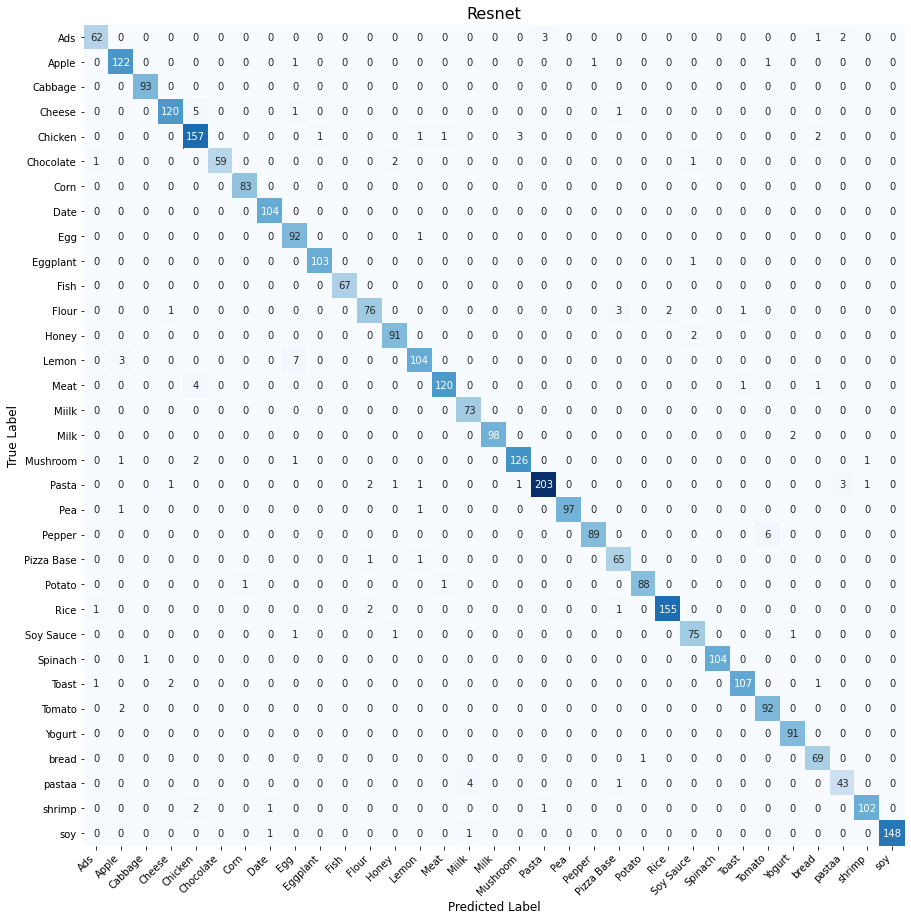

In [36]:
fig, ax1 = plt.subplots(1, figsize=(20, 10))
plot_heatmap(true_classes, pred_classes, class_subset, ax1, title="Resnet")    
fig.tight_layout()
fig.subplots_adjust(top=1.25)
plt.show()

In [38]:
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay

Y_pred = model.predict_generator(testgen)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
cm=confusion_matrix(testgen.classes, y_pred)
print(cm)
print('Classification Report')
#target_names = ['Cats', 'Dogs', 'Horse']
print(classification_report(testgen.classes, y_pred, target_names=class_subset))

<ipython-input-38-7cdfca30fbc1>:4: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  Y_pred = model.predict_generator(testgen)


Confusion Matrix
[[ 62   0   0 ...   2   0   0]
 [  0 122   0 ...   0   0   0]
 [  0   0  93 ...   0   0   0]
 ...
 [  0   0   0 ...  43   0   0]
 [  0   0   0 ...   0 102   0]
 [  0   0   0 ...   0   0 148]]
Classification Report
              precision    recall  f1-score   support

         Ads       0.95      0.91      0.93        68
       Apple       0.95      0.98      0.96       125
     Cabbage       0.99      1.00      0.99        93
      Cheese       0.97      0.94      0.96       127
     Chicken       0.92      0.95      0.94       165
   Chocolate       1.00      0.94      0.97        63
        Corn       0.99      1.00      0.99        83
        Date       0.98      1.00      0.99       104
         Egg       0.89      0.99      0.94        93
    Eggplant       0.99      0.99      0.99       104
        Fish       1.00      1.00      1.00        67
       Flour       0.94      0.92      0.93        83
       Honey       0.96      0.98      0.97        93
       Lemon

In [ ]:
#converter  = tf.lite.TFLiteConverter.from_saved_model("saved_model")
#converter.optimizations = [tf.lite.Optimize.DEFAULT]
#quantized_model = converter.convert()
#with open("quantized_resnet_model.tflite", "wb") as f:
#    f.write(quantized_model)